In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

# ensure project root (one level up) is on PATH
ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if ROOT not in sys.path:
    sys.path.insert(0, ROOT)

## Import the model

In [3]:
from utils.import_models import ModelImporter
players_model = ModelImporter().download_player_model()

Model downloaded to /home/bbrzyski/.cache/kagglehub/models/blaku03/player-detection/pyTorch/player_detectionv1_1/1


## Load the video generator and generate tracks

In [7]:
from trackers.player_detector import PlayerDetector
from assigners.team_assigner import TeamAssigner
from utils.video_utils import read_video, save_video

video_path = "../sample_data/08fd33_4.mp4"
output_path = "../output_videos/output_video.avi"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

frame_generator = read_video(video_path)

player_tracker = PlayerDetector(players_model)
tracks = player_tracker.get_detections_from_frames(frame_generator)


0: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 34.5ms
1: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 34.5ms
2: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 34.5ms
3: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 34.5ms
4: 544x960 1 ball, 1 goalkeeper, 20 players, 3 referees, 34.5ms
5: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 34.5ms
6: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 34.5ms
7: 544x960 1 goalkeeper, 21 players, 3 referees, 34.5ms
8: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 34.5ms
9: 544x960 1 ball, 1 goalkeeper, 21 players, 4 referees, 34.5ms
10: 544x960 1 ball, 1 goalkeeper, 21 players, 4 referees, 34.5ms
11: 544x960 1 goalkeeper, 24 players, 3 referees, 34.5ms
12: 544x960 1 ball, 1 goalkeeper, 22 players, 3 referees, 34.5ms
13: 544x960 1 ball, 1 goalkeeper, 21 players, 3 referees, 34.5ms
14: 544x960 1 ball, 21 players, 3 referees, 34.5ms
15: 544x960 1 ball, 21 players, 4 referees, 34.5ms
16: 544x960 1

ipdb>  n


> <string>(23)get_players_teams()



ipdb>  team_id


np.int32(0)


ipdb>  player_color


array([     215.54,      216.71,      221.11])


ipdb>  player_color.reshape(1, -1)


array([[     215.54,      216.71,      221.11]])


ipdb>  c


> <string>(22)get_players_teams()



ipdb>  q


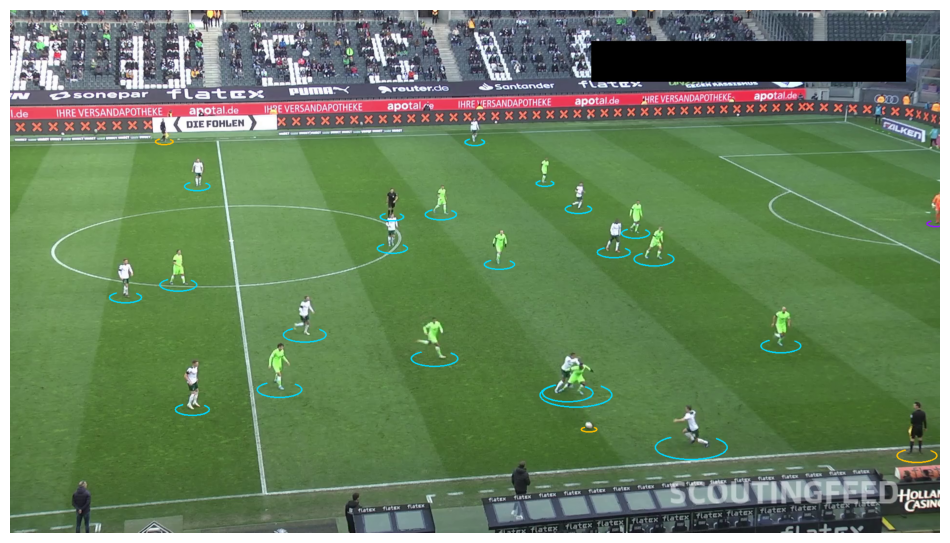

In [6]:
import supervision as sv
from utils.notebook_utils import show_image

ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(['#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)

frame_generator = read_video(video_path)
first_frame = next(frame_generator)

annotated_frame = ellipse_annotator.annotate(
    scene=first_frame,
    detections=tracks[0].detections)
show_image(first_frame)